<h1>Aerial Cactus Identification</h1>

<h2>Determine whether an image contains a columnar cactus</h2>

To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

<h2>Importing Libraries</h2>

In [67]:
import pandas as pd
import numpy as np
import torch
import shutil
import os

<h2>Sorting the data into classes</h2>

In [68]:
base_url = "dataset/"

In [69]:
df = pd.read_csv(base_url + 'train.csv')
df.head(10)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [70]:
image_names = df.id
has_cactus = df.has_cactus

In [87]:
folders = os.listdir(base_url + 'train')
if "has_cactus" not in folders:
    os.mkdir(base_url + 'train/has_cactus')
if "no_cactus" not in folders:
    os.mkdir(base_url + 'train/no_cactus')    

In [88]:
data = {image_name: target for image_name, target in zip(image_names, has_cactus)}

In [89]:
unsorted_images = os.listdir(base_url + 'train')
unsorted_images = [i for i in unsorted_images if i[-4:] == ".jpg"]
for i in unsorted_images:
    target = data[i]
    source = base_url + 'train/' + i
    if target == 1:
        destination = base_url + 'train/has_cactus/' + i
        shutil.move(source, destination)
    else:
        destination = base_url + 'train/no_cactus/' + i
        shutil.move(source, destination)

In [90]:
unsorted_images

[]

<h2>Data visualisation</h2>

In [77]:
import matplotlib.pyplot as plt

In [55]:
total_images_with_cactus = len(os.listdir(base_url + 'test/has_cactus/'))
total_images_without_cactus = len(os.listdir(base_url + 'test/no_cactus/'))

<function matplotlib.pyplot.show(*args, **kw)>

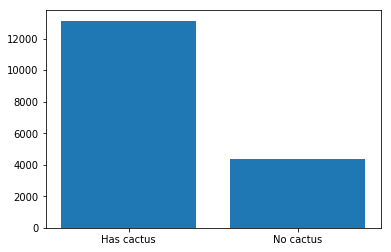

In [57]:
plt.bar(["Has cactus", "No cactus"], [total_images_with_cactus, total_images_without_cactus])
plt.show

<h2>Training the CNN network</h2>

In [64]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

In [100]:
batch_size = 32
learning_rate = 0.001
epochs = 10

In [101]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(8*8*32, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [102]:
model = CNNModel()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [103]:
def load_dataset():
    dataset = torchvision.datasets.ImageFolder(
        root='dataset/train/',
        transform=torchvision.transforms.ToTensor()
    )
    dataset_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return dataset_loader

In [104]:
loss_history = []
accuracy_history = []

dataset = load_dataset()
batches = len(dataset)

for j in range(0, epochs):
    for i, (images, labels) in enumerate(dataset):
        outputs = model(images)
        error = loss(outputs, labels)
        loss_history.append(error.item())
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy_history.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(j + 1, epochs, i + 1, batches, error.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [100/274], Loss: 0.2499, Accuracy: 93.75%
Epoch [1/10], Step [200/274], Loss: 0.1748, Accuracy: 89.06%
Epoch [2/10], Step [100/274], Loss: 0.0844, Accuracy: 95.31%
Epoch [2/10], Step [200/274], Loss: 0.1003, Accuracy: 95.31%
Epoch [3/10], Step [100/274], Loss: 0.1137, Accuracy: 95.31%
Epoch [3/10], Step [200/274], Loss: 0.0464, Accuracy: 100.00%
Epoch [4/10], Step [100/274], Loss: 0.0213, Accuracy: 100.00%
Epoch [4/10], Step [200/274], Loss: 0.0236, Accuracy: 98.44%
Epoch [5/10], Step [100/274], Loss: 0.0550, Accuracy: 98.44%
Epoch [5/10], Step [200/274], Loss: 0.0356, Accuracy: 98.44%
Epoch [6/10], Step [100/274], Loss: 0.0474, Accuracy: 98.44%
Epoch [6/10], Step [200/274], Loss: 0.2187, Accuracy: 95.31%
Epoch [7/10], Step [100/274], Loss: 0.0184, Accuracy: 98.44%
Epoch [7/10], Step [200/274], Loss: 0.0183, Accuracy: 98.44%
Epoch [8/10], Step [100/274], Loss: 0.0135, Accuracy: 100.00%
Epoch [8/10], Step [200/274], Loss: 0.0153, Accuracy: 100.00%
Epoch [9/10], Step [

<h2>Evaluating the model</h2>

In [105]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in dataset:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 99.5657142857143 %


<h2>Predicting for Kaggle submission</h2>

In [112]:
def load_submission_dataset():
    dataset = torchvision.datasets.ImageFolder(
        root='dataset/test',
        transform=torchvision.transforms.ToTensor()
    )
    dataset_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        num_workers=0,
        shuffle=True
    )
    return dataset_loader

In [120]:
model.eval()
predictions = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in load_submission_dataset():
        outputs = model(images)
        _, result = torch.max(outputs.data, 1)
        predictions.append(result)

In [122]:
predictions = np.array(predictions)
image_id = os.listdir(base_url + 'test/prediction')
submission = pd.DataFrame({'id':image_id, 'has_cactus':predictions})

In [125]:
submission.to_csv('submission.csv', index = False)